### Importing the Libraries

In [12]:
import numpy as np
import pandas as pd
import logging
import pyLDAvis.gensim_models
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

### Reading the data

In [9]:
df=pd.read_csv('CEO.csv')

#### Converting the data to an array

In [11]:
docs=array(df['line'])

### Data Preprocessing

In [13]:
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

In [14]:
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

### Creating the dictionary and corpus

In [15]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 3384
Number of documents: 8922
[[(0, 1)]]


### Training the model

In [16]:
# Set parameters.
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.035*"talked_about" + 0.031*"talk_about" + 0.019*"when_look" + 0.015*"talk" + 0.015*"talked" + 0.014*"three_year" + 0.013*"cash_flow" + 0.013*"look" + 0.013*"balance_sheet" + 0.012*"demand"'), (1, '0.015*"more" + 0.014*"right" + 0.013*"just" + 0.013*"customer" + 0.012*"company" + 0.012*"thing" + 0.011*"people" + 0.011*"great" + 0.010*"going" + 0.010*"like"'), (2, '0.027*"over" + 0.016*"million" + 0.015*"been" + 0.013*"united_state" + 0.012*"will" + 0.012*"next" + 0.012*"next_year" + 0.012*"billion" + 0.011*"billion_dollar" + 0.011*"than"'), (3, '0.035*"growth" + 0.032*"quarter" + 0.027*"last_year" + 0.024*"good" + 0.020*"last" + 0.020*"long_term" + 0.017*"very_strong" + 0.016*"term" + 0.015*"strong" + 0.012*"market"'), (4, '0.027*"brand" + 0.020*"world" + 0.019*"more_than" + 0.017*"product" + 0.016*"around_world" + 0.013*"talking_about" + 0.012*"data" + 0.012*"excited_about" + 0.011*"care" + 0.010*"health_care"')]


### Computing the coherence score

In [17]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.23245798145507815


### k-Elbow Plot for Coherence Score

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

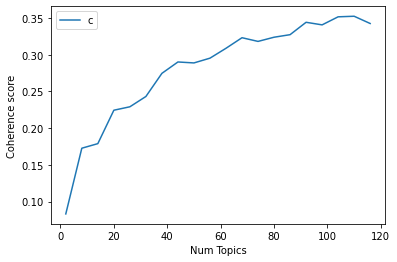

In [21]:
del_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=120, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=120; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Shows highest coherence score at around 100 topics

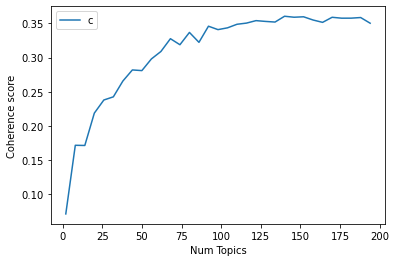

In [22]:
del_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=200, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=200; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()